In [80]:
import numpy as np 
import numpy.random as rng
import torch as th
import matplotlib.pyplot as plt
import torch.distributions as D
import copy

In [2]:
def sample_mixture_gaussians(mixture_coeff, mu, sigma, n_samples, hard=False):
    rv = th.randn((n_samples, mu.shape[0])) * sigma + mu 
    components = th.nn.functional.gumbel_softmax(th.tile(mixture_coeff, (n_samples,1)), tau=0.5, hard=hard)
    samples = (rv * components).sum(1)
    return samples 

torch.Size([100, 50])

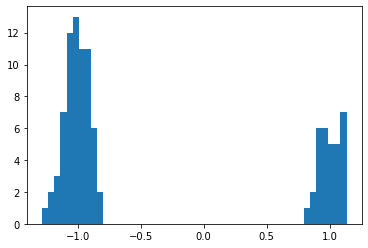

In [203]:
mu = th.tensor([-1, 1]).float()
sigma = th.tensor([0.1, 0.1]).float()
mixture_coeff_logits = th.tensor([1, 0]).float()

n_students = 100
n_trials = 50

with th.no_grad():
    abilities = sample_mixture_gaussians(mixture_coeff_logits, mu, sigma, n_students, hard=True)
    probs = th.sigmoid(abilities)
    trial_probs = th.tile(probs, (n_trials, 1)).T
    y = th.bernoulli(trial_probs).float()

plt.hist(abilities.numpy(), bins=50)
y.shape

Train: 2325.6907, Valid: 617.7676
Train: 2307.9282, Valid: 613.0480
Train: 2290.0676, Valid: 608.4716
Train: 2274.2588, Valid: 604.6531
Train: 2261.6106, Valid: 601.8153
Train: 2251.9941, Valid: 599.8135
Train: 2244.8396, Valid: 598.4216
Train: 2239.5757, Valid: 597.4563
Train: 2235.7334, Valid: 596.7876
Train: 2232.9470, Valid: 596.3251
Train: 2230.9375, Valid: 596.0055
Train: 2229.4961, Valid: 595.7847
Train: 2228.4658, Valid: 595.6323
Train: 2227.7314, Valid: 595.5272
Train: 2227.2041, Valid: 595.4546
Train: 2226.8159, Valid: 595.4041
Train: 2226.5129, Valid: 595.3680
Train: 2226.2515, Valid: 595.3403
Train: 2225.9912, Valid: 595.3156
Train: 2225.6919, Valid: 595.2890
Train: 2225.3025, Valid: 595.2545
Train: 2224.7478, Valid: 595.2039
Train: 2223.8984, Valid: 595.1237
Train: 2222.5261, Valid: 594.9902
Train: 2220.2524, Valid: 594.7634
Train: 2216.6575, Valid: 594.3986
Train: 2211.9031, Valid: 593.9102
Train: 2207.1140, Valid: 593.3705
Train: 2203.1411, Valid: 592.8206
Train: 2200.07

(array([  3.,  10.,  23.,  51.,  74., 143., 212., 282., 352., 426., 436.,
        370., 350., 249., 185., 117.,  50.,  33.,  15.,   6.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   4.,  10.,
         25.,  32.,  68., 111., 165., 167., 206., 242., 197., 136., 104.,
         75.,  35.,  16.,  10.,   5.,   1.]),
 array([-1.8372052e+00, -1.7637182e+00, -1.6902313e+00, -1.6167445e+00,
        -1.5432576e+00, -1.4697707e+00, -1.3962837e+00, -1.3227968e+00,
        -1.2493100e+00, -1.1758231e+00, -1.1023362e+00, -1.0288492e+00,
        -9.5536238e-01, -8.8187546e-01, -8.0838859e-01, -7.3490167e-01,
        -6.6141474e-01, -5.8792788e-01, -5.1444095e-01, -4.4095406e-01,
        -3.6746716e-01, -2.9398027e-01, -2.2049336e-01, -1.4700647e-01,
        -7.3519565e-02, -3.2663345e-05,  7.3454238e-02,  1.4694114e-01,
         2.2042803e-01,  2.9391494e-01,  3.6740184e-01,  4.4088873e-01,
         5.1437563e-01,  5.8786255e-01,  6.6134942e-01,  7.3483634e-01,
         8

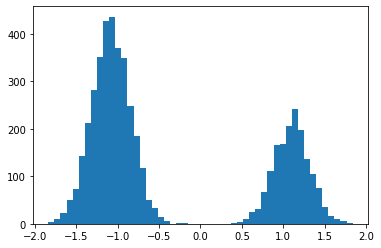

In [204]:
with th.no_grad():
    abilities_grid = th.linspace(-3, 3, 30)
    
repy = th.tile(y[:,:,None], (1,1,abilities_grid.shape[0]))

n_components = 2

weight_logits = th.nn.Parameter(th.randn(n_components,))
component_mu = th.nn.Parameter(th.randn(n_components,))
component_log_std = th.nn.Parameter(th.randn(n_components,))

params = [weight_logits, component_mu, component_log_std]
opt = th.optim.Adam(params, lr = 0.001)

best_valid_loss = th.inf 
patience = 500
wait_counter = 0

best_params = []

train_y = repy[:80,:,:]
valid_y = repy[80:,:,:]

for e in range(10000):
    
    mix = D.Categorical(logits=weight_logits)
    comp = D.Normal(component_mu, th.exp(component_log_std))
    gmm = D.MixtureSameFamily(mix, comp)
    
    alpha = th.tile(abilities_grid, (train_y.shape[0], train_y.shape[1],1))
    prob_one = th.sigmoid(alpha)
    logprior = gmm.log_prob(alpha)
    loglik = ((train_y * th.log(prob_one) + (1-train_y) * th.log(1-prob_one))).sum(1)
    loss = -th.logsumexp(loglik + logprior[:,0,:], dim=1).sum()

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    with th.no_grad():
        mix = D.Categorical(logits=weight_logits)
        comp = D.Normal(component_mu, th.exp(component_log_std))
        gmm = D.MixtureSameFamily(mix, comp)

        
        alpha = th.tile(abilities_grid, (valid_y.shape[0], valid_y.shape[1],1))
        prob_one = th.sigmoid(alpha)
        logprior = gmm.log_prob(alpha)
        loglik = ((valid_y * th.log(prob_one) + (1-valid_y) * th.log(1-prob_one))).sum(1)
        valid_loss = -th.logsumexp(loglik + logprior[:,0,:], dim=1).sum()


        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_params = copy.deepcopy(params)
            wait_counter = 0
        else:
            wait_counter += 1
        
        if wait_counter >= patience:
            break
        
    if e % 100 == 0:
        print("Train: %8.4f, Valid: %8.4f" % (loss.item(), valid_loss.item()))
    
    
with th.no_grad():
    weight_logits, component_mu, component_log_std = best_params
    mix = D.Categorical(logits=weight_logits)
    comp = D.Normal(component_mu, th.exp(component_log_std))
    gmm = D.MixtureSameFamily(mix, comp)

    fitted_samples = gmm.sample((5000,))

plt.hist(fitted_samples.numpy(), bins=50)

In [108]:
# Using the sampling approach

In [206]:
n_components = 10

weight_logits = th.nn.Parameter(th.randn(n_components,))
component_mu = th.nn.Parameter(th.randn(n_components,))
component_log_std = th.nn.Parameter(th.randn(n_components,))

params = [weight_logits, component_mu, component_log_std]
opt = th.optim.Adam(params, lr = 0.01)

best_valid_loss = th.inf 
patience = 500
wait_counter = 0

best_params = []

train_y = y[:80,:]
valid_y = repy[80:,:]

for e in range(10000):
    
    sampled_alpha = sample_mixture_gaussians(weight_logits, component_mu, th.exp(component_log_std), train_y.shape[0], hard=True)
    sampled_alpha = th.tile(sampled_alpha[:,None], (1,n_trials))

    prob_one = th.sigmoid(sampled_alpha)
    loglik = ((train_y * th.log(prob_one) + (1-train_y) * th.log(1-prob_one))).sum(1)
    loss = -loglik.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    with th.no_grad():
        mix = D.Categorical(logits=weight_logits)
        comp = D.Normal(component_mu, th.exp(component_log_std))
        gmm = D.MixtureSameFamily(mix, comp)

        
        alpha = th.tile(abilities_grid, (valid_y.shape[0], valid_y.shape[1],1))
        prob_one = th.sigmoid(alpha)
        logprior = gmm.log_prob(alpha)
        loglik = ((valid_y * th.log(prob_one) + (1-valid_y) * th.log(1-prob_one))).sum(1)
        valid_loss = -th.logsumexp(loglik + logprior[:,0,:], dim=1).sum()


        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_params = copy.deepcopy(params)
            wait_counter = 0
        else:
            wait_counter += 1
        
        if wait_counter >= patience:
            break
        
    if e % 100 == 0:
        print("Train: %8.4f, Valid: %8.4f" % (loss.item(), valid_loss.item()))
    
    
with th.no_grad():
    weight_logits, component_mu, component_log_std = best_params
    mix = D.Categorical(logits=weight_logits)
    comp = D.Normal(component_mu, th.exp(component_log_std))
    gmm = D.MixtureSameFamily(mix, comp)

    fitted_samples = gmm.sample((5000,))

plt.hist(fitted_samples.numpy(), bins=50)

Train:  75.6145, Valid: 602.0123


ValueError: Expected parameter logits (Tensor of shape (10,)) of distribution Categorical(logits: torch.Size([10])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Train: 124.6394, Valid: 589.1577
Train: 138.3219, Valid: 589.0307
Train: 136.7190, Valid: 588.9079
Train: 132.4312, Valid: 588.7846
Train: 129.0193, Valid: 588.6708
Train: 144.6058, Valid: 588.5452
Train: 136.0887, Valid: 588.4255
Train: 144.6889, Valid: 588.3069
Train: 124.0164, Valid: 588.1868
Train: 163.3638, Valid: 588.0729
Train: 124.8057, Valid: 587.9496
Train: 132.7272, Valid: 587.8386
Train: 128.2538, Valid: 587.7273
Train: 136.1353, Valid: 587.6137
Train: 135.6065, Valid: 587.4987
Train: 142.0761, Valid: 587.3851
Train: 155.0099, Valid: 587.2712
Train: 151.5360, Valid: 587.1552
Train: 126.2902, Valid: 587.0523
Train: 149.2300, Valid: 586.9416
Train: 137.6225, Valid: 586.8326
Train: 149.6550, Valid: 586.7274
Train: 127.2142, Valid: 586.6213
Train: 144.9830, Valid: 586.5084
Train: 122.2919, Valid: 586.4008
Train: 147.0993, Valid: 586.2943
Train: 133.3487, Valid: 586.1911
Train: 124.1325, Valid: 586.0867
Train: 121.1937, Valid: 585.9851
Train: 120.2776, Valid: 585.8817
Train: 130

(array([  2.,   1.,   1.,   3.,   9.,  20.,  28.,  36.,  49.,  59.,  73.,
         74., 102., 120., 136., 154., 141., 179., 216., 287., 280., 341.,
        328., 319., 335., 289., 229., 190., 172., 133.,  97.,  71.,  54.,
         45.,  31.,  33.,  44.,  45.,  34.,  40.,  34.,  40.,  26.,  22.,
         30.,   9.,  18.,   9.,   7.,   5.]),
 array([-7.515113  , -7.2225432 , -6.929974  , -6.6374044 , -6.3448353 ,
        -6.0522656 , -5.7596965 , -5.467127  , -5.1745577 , -4.881988  ,
        -4.589419  , -4.2968493 , -4.00428   , -3.7117105 , -3.419141  ,
        -3.1265717 , -2.8340023 , -2.5414329 , -2.2488635 , -1.9562941 ,
        -1.6637247 , -1.3711553 , -1.0785859 , -0.78601646, -0.49344707,
        -0.20087767,  0.09169174,  0.38426116,  0.67683053,  0.9694    ,
         1.2619693 ,  1.5545387 ,  1.8471082 ,  2.1396775 ,  2.432247  ,
         2.7248163 ,  3.0173857 ,  3.3099551 ,  3.6025248 ,  3.8950942 ,
         4.1876636 ,  4.4802327 ,  4.7728024 ,  5.0653715 ,  5.357941  ,
 

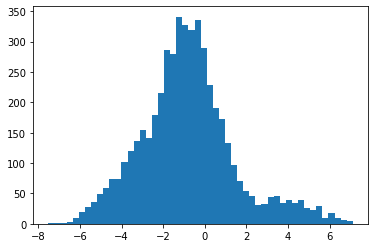

In [197]:
n_components = 10
min_val = -5
max_val = 5

weight_logits = th.nn.Parameter(th.randn(n_components,))
component_mu = th.linspace(min_val, max_val, n_components)
component_log_std = th.zeros_like(component_mu)

params = [weight_logits]
opt = th.optim.Adam(params, lr = 0.0001)

best_valid_loss = th.inf 
patience = 100
wait_counter = 0

best_params = []

train_y = y[:80,:]
valid_y = repy[80:,:]

for e in range(10000):
    
    sampled_alpha = sample_mixture_gaussians(weight_logits, component_mu, th.exp(component_log_std), train_y.shape[0], hard=True)
    sampled_alpha = th.tile(sampled_alpha[:,None], (1,n_trials))

    prob_one = th.sigmoid(sampled_alpha)
    loglik = ((train_y * th.log(prob_one) + (1-train_y) * th.log(1-prob_one))).sum(1)
    loss = -loglik.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    with th.no_grad():
        mix = D.Categorical(logits=weight_logits)
        comp = D.Normal(component_mu, th.exp(component_log_std))
        gmm = D.MixtureSameFamily(mix, comp)

        
        alpha = th.tile(abilities_grid, (valid_y.shape[0], valid_y.shape[1],1))
        prob_one = th.sigmoid(alpha)
        logprior = gmm.log_prob(alpha)
        loglik = ((valid_y * th.log(prob_one) + (1-valid_y) * th.log(1-prob_one))).sum(1)
        valid_loss = -th.logsumexp(loglik + logprior[:,0,:], dim=1).sum()


        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_params = copy.deepcopy(params)
            wait_counter = 0
        else:
            wait_counter += 1
        
        if wait_counter >= patience:
            break
        
    if e % 100 == 0:
        print("Train: %8.4f, Valid: %8.4f" % (loss.item(), valid_loss.item()))
    
    
with th.no_grad():
    weight_logits = best_params[0]
    mix = D.Categorical(logits=weight_logits)
    comp = D.Normal(component_mu, th.exp(component_log_std))
    gmm = D.MixtureSameFamily(mix, comp)

    fitted_samples = gmm.sample((5000,))

plt.hist(fitted_samples.numpy(), bins=50)

In [ ]:
# Fit alphas using uniform prior then sample from that distribution, with replacement

In [ ]:
student_alpha = th.nn.Parameter(
params = [weight_logits, component_mu, component_log_std]
opt = th.optim.Adam(params, lr = 0.01)

best_valid_loss = th.inf 
patience = 500
wait_counter = 0

best_params = []

train_y = y[:80,:]
valid_y = repy[80:,:]

for e in range(10000):
    
    sampled_alpha = sample_mixture_gaussians(weight_logits, component_mu, th.exp(component_log_std), train_y.shape[0], hard=True)
    sampled_alpha = th.tile(sampled_alpha[:,None], (1,n_trials))

    prob_one = th.sigmoid(sampled_alpha)
    loglik = ((train_y * th.log(prob_one) + (1-train_y) * th.log(1-prob_one))).sum(1)
    loss = -loglik.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    with th.no_grad():
        mix = D.Categorical(logits=weight_logits)
        comp = D.Normal(component_mu, th.exp(component_log_std))
        gmm = D.MixtureSameFamily(mix, comp)

        
        alpha = th.tile(abilities_grid, (valid_y.shape[0], valid_y.shape[1],1))
        prob_one = th.sigmoid(alpha)
        logprior = gmm.log_prob(alpha)
        loglik = ((valid_y * th.log(prob_one) + (1-valid_y) * th.log(1-prob_one))).sum(1)
        valid_loss = -th.logsumexp(loglik + logprior[:,0,:], dim=1).sum()


        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_params = copy.deepcopy(params)
            wait_counter = 0
        else:
            wait_counter += 1
        
        if wait_counter >= patience:
            break
        
    if e % 100 == 0:
        print("Train: %8.4f, Valid: %8.4f" % (loss.item(), valid_loss.item()))
    
    
with th.no_grad():
    weight_logits, component_mu, component_log_std = best_params
    mix = D.Categorical(logits=weight_logits)
    comp = D.Normal(component_mu, th.exp(component_log_std))
    gmm = D.MixtureSameFamily(mix, comp)

    fitted_samples = gmm.sample((5000,))

plt.hist(fitted_samples.numpy(), bins=50)